# Calibrate with particles 

The idea is to run PyPTV as usual, and check the box "Use only 4 frames". The result will be in the /res folder with only quadruplets as 3D and the respective indices of 2D targets per image

If we read this dataset into the proper format, we can now reproject every 3D point in rt_is back into the image and then optimize calibration with disparity between the position of the target as detected and the reprojected center. 

In [105]:
# from Yosef Meller's PBI

import shutil
import numpy as np
import numpy.random as rnd
from optv.calibration import Calibration
from optv.imgcoord import image_coordinates
from optv.transforms import convert_arr_metric_to_pixel
from optv.segmentation import target_recognition
from optv.imgcoord import image_coordinates
from optv.transforms import convert_arr_metric_to_pixel
from optv.orientation import match_detection_to_ref
from optv.orientation import external_calibration, full_calibration
from optv.calibration import Calibration
from optv.tracking_framebuf import TargetArray


from pyptv import ptv, parameter_gui, parameters as par

In [106]:
import os
from pathlib import Path

present_folder = Path.cwd()

working_folder = Path("/home/user/Documents/repos/test_cavity")
par_path = working_folder / "parameters"
working_folder.exists(), par_path.exists()


(True, True)

In [107]:
def load_parameters(n_cams):
    
    from optv.parameters import (
    ControlParams,
    VolumeParams,
    TrackingParams,
    SequenceParams,
    TargetParams,
    MultimediaParams,
    )
    
    # Control parameters
    cpar = ControlParams(n_cams)
    cpar.read_control_par(b"ptv.par")

    # Sequence parameters
    spar = SequenceParams(num_cams=n_cams)
    spar.read_sequence_par(b"sequence.par", n_cams)

    # Volume parameters
    vpar = VolumeParams()
    vpar.read_volume_par(b"criteria.par")

    # Tracking parameters
    track_par = TrackingParams()
    track_par.read_track_par(b"track.par")

    # Target parameters
    tpar = TargetParams(n_cams)
    tpar.read(b"targ_rec.par")

    # Examine parameters, multiplane (single plane vs combined calibration)
    epar = par.ExamineParams(path = '../')
    epar.read()

    return cpar, spar, vpar, track_par, tpar, epar


In [108]:

# Read parameters

n_cams = 4
os.chdir(par_path)
cpar, spar, vpar, track_par, tpar, epar  = load_parameters(n_cams)

os.chdir(working_folder)
# Calibration parameters
cals = []
for i_cam in range(n_cams):
    cal = Calibration()
    tmp = cpar.get_cal_img_base_name(i_cam)
    cal.from_file(tmp + b".ori", tmp + b".addpar")
    cals.append(cal)


In [109]:
def get_pos(inters, R, angs):
    # Transpose of http://planning.cs.uiuc.edu/node102.html
    # Also consider the angles are reversed when moving from camera frame to
    # global frame.
    s = np.sin(angs)
    c = np.cos(angs)
    pos = inters + R*np.r_[ s[1], -c[1]*s[0], c[1]*c[0] ]
    return pos

def get_polar_rep(pos, angs):
    """
    Returns the point of intersection with zero Z plane, and distance from it.
    """
    s = np.sin(angs)
    c = np.cos(angs)
    zdir = -np.r_[ s[1], -c[1]*s[0], c[1]*c[0] ]
    
    c = -pos[2]/zdir[2]
    inters = pos + c*zdir
    R = np.linalg.norm(inters - pos)
    
    return inters[:2], R
    
def gen_calib(inters, R, angs, glass_vec, prim_point, radial_dist, decent):
    pos = get_pos(inters, R, angs)
    return Calibration(pos, angs, prim_point, radial_dist, decent, 
        np.r_[1, 0], glass_vec)

def fitness(solution, calib_targs, calib_detect, glass_vec, cpar):
    """
    Checks the fitness of an evolutionary solution of calibration values to 
    target points. Fitness is the sum of squares of the distance from each 
    guessed point to the closest neighbor.
    
    Arguments:
    solution - array, concatenated: position of intersection with Z=0 plane; 3 
        angles of exterior calibration; primary point (xh,yh,cc); 3 radial
        distortion parameters; 2 decentering parameters.
    calib_targs - a (p,3) array of p known points on the calibration target.
    calib_detect - a (d,2) array of d detected points in the calibration 
        target.
    cpar - a ControlParams object with image data.
    """
    # Breakdown of of agregate solution vector:
    inters = np.zeros(3)
    inters[:2] = solution[:2]
    R = solution[2]
    angs = solution[3:6] 
    prim_point = solution[6:9]
    rad_dist = solution[9:12]
    decent = solution[12:14]
        
    # Compare known points' projections to detections:
    cal = gen_calib(inters, R, angs, glass_vec, prim_point, rad_dist, decent)
    known_proj = image_coordinates(calib_targs, cal, 
        cpar.get_multimedia_params())
    known_2d = convert_arr_metric_to_pixel(known_proj, cpar)
    dists = np.linalg.norm(
        known_2d[None,:,:] - calib_detect[:,None,:], axis=2).min(axis=0)
    
    return np.sum(dists**2)


In [110]:

calOriParams = par.CalOriParams(path = par_path)


In [111]:
def g(f):
    """ Returns a line without white spaces """
    return f.readline().strip()

def read(filepath, n_img = 4):
    with open(filepath, "r") as f:

        fixp_name = Path(g(f))
        fixp_name.exists()

        img_cal_name = []
        img_ori = []
        for i in range(n_img):
            img_cal_name.append(g(f))
            img_ori.append(g(f))

        tiff_flag = int(g(f)) != 0  # <-- overwrites the above
        pair_flag = int(g(f)) != 0
        chfield = int(g(f))


    # test if files are present, issue warnings
    for i in range(n_img):
        Path(img_cal_name[i]).exists()
        Path(img_ori[i]).exists()

    return fixp_name, img_cal_name, img_ori, tiff_flag, pair_flag, chfield


In [112]:
fixp_name, img_cal_name, img_ori, tiff_flag, pair_flag, chfield = read(par_path / "cal_ori.par")
img_cal_name, img_ori

(['cal/cam1.tif', 'cal/cam2.tif', 'cal/cam3.tif', 'cal/cam4.tif'],
 ['cal/cam1.tif.ori',
  'cal/cam2.tif.ori',
  'cal/cam3.tif.ori',
  'cal/cam4.tif.ori'])

In [113]:
list(calOriParams.path.rglob('*.par'))

[PosixPath('/home/user/Documents/repos/test_cavity/parameters/multi_planes.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/criteria.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/track.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/detect_plate.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/sequence.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/shaking.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/man_ori.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/orient.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/targ_rec.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/examine.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/cal_ori.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters/unsharp_mask.par'),
 PosixPath('/home/user/Documents/repos/test_cavity/parameters

In [114]:

op = par.OrientParams()
op.read()

# recognized names for the flags:
names = [
    "cc",
    "xh",
    "yh",
    "k1",
    "k2",
    "k3",
    "p1",
    "p2",
    "scale",
    "shear",
]
op_names = [
    op.cc,
    op.xh,
    op.yh,
    op.k1,
    op.k2,
    op.k3,
    op.p1,
    op.p2,
    op.scale,
    op.shear,
]

flags = []
for name, op_name in zip(names, op_names):
    if op_name == 1:
        flags.append(name)

In [115]:
from pyptv.ptv import read_targets

In [152]:
# def read_rt_is_files_with_targets(path, n_cams):
"""Reads all rt_is.* files from the specified path and returns a list of 3D points and their corresponding targets."""
path = working_folder
rt_is_files = sorted(list((path / "res").rglob("rt_is.*")))

n_frames = len(rt_is_files)

# Initialize a list of lists to hold TargetArray objects
targets = [[TargetArray() for _ in range(n_cams)] for _ in range(n_frames)]
points = [[] for _ in range(n_frames)]
ids = [[] for _ in range(n_frames)]


for i, file in enumerate(rt_is_files):
    frame_num = int(file.name.split(".")[1])
    print(f" frame_num {frame_num}")
    with open(file, "r") as f:
        num_points = int(f.readline().strip())
        for _ in range(num_points):
            data = f.readline().strip().split()
            points[i].append([float(data[1]), float(data[2]), float(data[3])])
            ids[i].append([int(data[4]), int(data[5]), int(data[6]), int(data[7])])

    for i_cam in range(n_cams):
        target_file = path / "img" / f"cam{i_cam+1:d}.{frame_num:d}"
        targets[i][i_cam] = read_targets(str(target_file))
        
        # return np.array(points), targets


 frame_num 10001
 filename: /home/user/Documents/repos/test_cavity/img/cam1.10001_targets
 filename: /home/user/Documents/repos/test_cavity/img/cam2.10001_targets
 filename: /home/user/Documents/repos/test_cavity/img/cam3.10001_targets
 filename: /home/user/Documents/repos/test_cavity/img/cam4.10001_targets
 frame_num 10002
 filename: /home/user/Documents/repos/test_cavity/img/cam1.10002_targets
 filename: /home/user/Documents/repos/test_cavity/img/cam2.10002_targets
 filename: /home/user/Documents/repos/test_cavity/img/cam3.10002_targets
 filename: /home/user/Documents/repos/test_cavity/img/cam4.10002_targets
 frame_num 10003
 filename: /home/user/Documents/repos/test_cavity/img/cam1.10003_targets
 filename: /home/user/Documents/repos/test_cavity/img/cam2.10003_targets
 filename: /home/user/Documents/repos/test_cavity/img/cam3.10003_targets
 filename: /home/user/Documents/repos/test_cavity/img/cam4.10003_targets
 frame_num 10004
 filename: /home/user/Documents/repos/test_cavity/img/ca

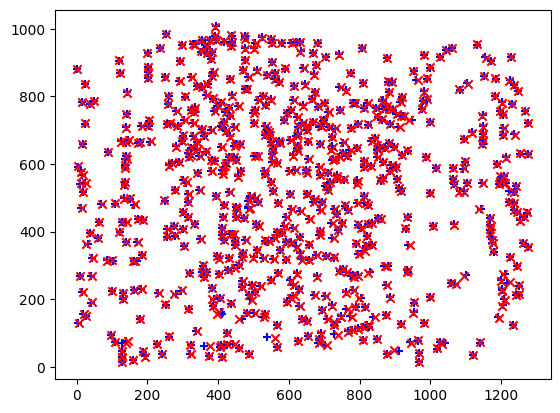

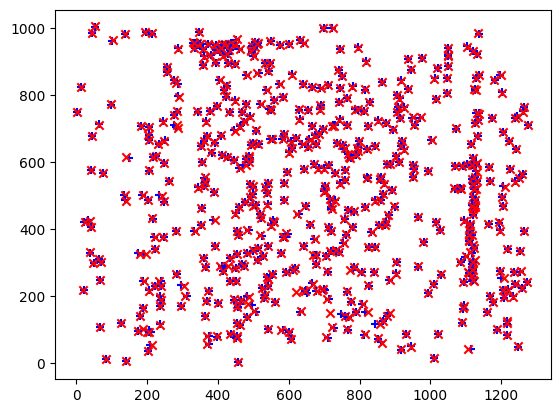

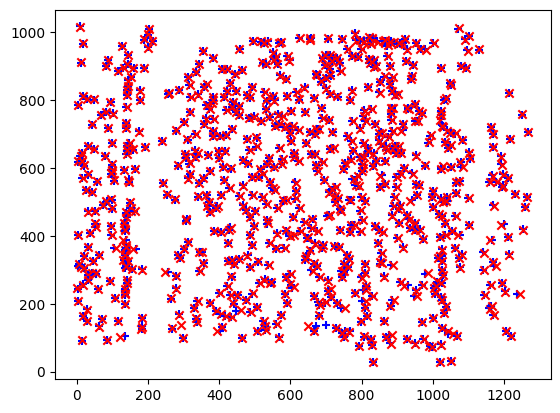

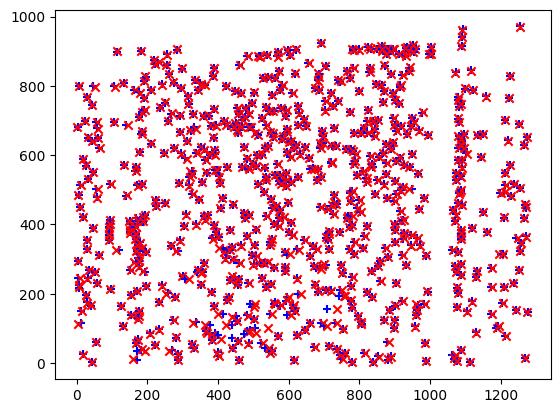

In [170]:
from optv.transforms import convert_arr_metric_to_pixel
import matplotlib.pyplot as plt

i_frame = 0
err = 0

for i_cam in range(n_cams):
    fig, ax = plt.subplots()
    for i_point in range(len(points[i_frame])):
        if ids[i_frame][i_point][i_cam] != -1:
            tmp = convert_arr_metric_to_pixel(
                        image_coordinates(np.atleast_2d(points[i_frame][i_point]), cals[i_cam], cpar.get_multimedia_params()),
                        cpar
                    )
            x, y  = targets[i_frame][i_cam][ids[i_frame][i_point][i_cam]].pos()


            ax.scatter(x, y, marker='+', color = 'blue')
            ax.scatter(tmp[0,0], tmp[0,1], marker='x', color = 'red')
            

            err += np.sum((tmp - targets[i_frame][i_cam][ids[i_frame][i_point][i_cam]].pos())**2)
        

In [ ]:

        # backup the ORI/ADDPAR files first
        self.backup_ori_files()

        op = par.OrientParams()
        op.read()

        flags = [name for name in NAMES if getattr(op, name) == 1]

        for i_cam in range(self.n_cams):  # iterate over all cameras

            if self.epar.Combine_Flag:

                self.status_text = "Multiplane calibration."
                """ Performs multiplane calibration, in which for all cameras the
                pre-processed planes in multi_plane.par combined.
                Overwrites the ori and addpar files of the cameras specified
                in cal_ori.par of the multiplane parameter folder
                """

                all_known = []
                all_detected = []

                for i in range(
                    self.MultiParams.n_planes
                ):  # combine all single planes

                    # c = self.calParams.img_ori[i_cam][-9] # Get camera id
                    # not all ends with a number
                    # c = re.findall("\\d+", self.calParams.img_ori[i_cam])[0]
                    match = re.search(r'cam[_-]?(\d)', self.calParams.img_ori[i_cam])
                    if match:
                        c = match.group(1)
                        print(f'Camera number found: {c} in {self.calParams.img_ori[i_cam]}')
                    else:
                        raise ValueError("Camera number not found in {}".format(self.calParams.img_ori[i_cam]))


                    file_known = (
                        self.MultiParams.plane_name[i] + c + ".tif.fix"
                    )
                    file_detected = (
                        self.MultiParams.plane_name[i] + c + ".tif.crd"
                    )

                    # Load calibration point information from plane i
                    try:
                        known = np.loadtxt(file_known)
                        detected = np.loadtxt(file_detected)
                    except BaseException:
                        raise IOError(
                            "reading {} or {} failed".format(
                                file_known, file_detected
                            )
                        )

                    if np.any(detected == -999):
                        raise ValueError(
                            (
                                "Using undetected points in {} will cause "
                                + "silliness. Quitting."
                            ).format(file_detected)
                        )

                    num_known = len(known)
                    num_detect = len(detected)

                    if num_known != num_detect:
                        raise ValueError(
                            f"Number of detected points {num_known} does not match"
                            " number of known points {num_detect} for \
                                {file_known}, {file_detected}")

                    if len(all_known) > 0:
                        detected[:, 0] = (
                            all_detected[-1][-1, 0]
                            + 1
                            + np.arange(len(detected))
                        )

                    # Append to list of total known and detected points
                    all_known.append(known)
                    all_detected.append(detected)

                # Make into the format needed for full_calibration.
                all_known = np.vstack(all_known)[:, 1:]
                all_detected = np.vstack(all_detected)

                # this is the main difference in the multiplane mode
                # that we fill the targs and cal_points by the
                # combined information

                targs = TargetArray(len(all_detected))
                for tix in range(len(all_detected)):
                    targ = targs[tix]
                    det = all_detected[tix]

                    targ.set_pnr(tix)
                    targ.set_pos(det[1:])

                self.cal_points = np.empty((all_known.shape[0],)).astype(
                    dtype=[("id", "i4"), ("pos", "3f8")]
                )
                self.cal_points["pos"] = all_known
            else:
                targs = self.sorted_targs[i_cam]

            # end of multiplane calibration loop that combines planes

            try:
                print(f"Calibrating external (6DOF) and flags: {flags} \n")
                residuals, targ_ix, err_est = full_calibration(
                    self.cals[i_cam],
                    self.cal_points["pos"],
                    targs,
                    self.cpar,
                    flags,
                )
            except BaseException:
                print("Error in OPTV full_calibration, attempting Scipy")
                # raise
            
                # this chunk optimizes for radial distortion

                if any(flag in flags for flag in ['k1', 'k2', 'k3']):
                    sol = minimize(self._residuals_k,
                                self.cals[i_cam].get_radial_distortion(), 
                                args=(self.cals[i_cam], 
                                        self.cal_points["pos"], 
                                        targs,
                                        self.cpar
                                        ), 
                                        method='Nelder-Mead', 
                                        tol=1e-11,
                                        options={'disp':True},
                                        )
                    radial = sol.x 
                    self.cals[i_cam].set_radial_distortion(radial)
                else:
                    radial = self.cals[i_cam].get_radial_distortion()
                
                if any(flag in flags for flag in ['p1', 'p2']):
                    # now decentering
                    sol = minimize(self._residuals_p,
                                self.cals[i_cam].get_decentering(), 
                                args=(self.cals[i_cam], 
                                        self.cal_points["pos"], 
                                        targs,
                                        self.cpar
                                        ), 
                                        method='Nelder-Mead', 
                                        tol=1e-11,
                                        options={'disp':True},
                                        )
                    decentering = sol.x 
                    self.cals[i_cam].set_decentering(decentering)
                else:
                    decentering = self.cals[i_cam].get_decentering()
                
                if any(flag in flags for flag in ['scale', 'shear']):
                    # now affine
                    sol = minimize(self._residuals_s,
                                self.cals[i_cam].get_affine(), 
                                args=(self.cals[i_cam], 
                                        self.cal_points["pos"], 
                                        targs,
                                        self.cpar
                                        ), 
                                        method='Nelder-Mead', 
                                        tol=1e-11,
                                        options={'disp':True},
                                        )
                    affine = sol.x 
                    self.cals[i_cam].set_affine_trans(affine)

                else:
                    affine = self.cals[i_cam].get_affine()
                


                # Now project and estimate full residuals
                self._project_cal_points(i_cam)

                residuals = self._residuals_combined(
                                np.r_[radial, decentering, affine],
                                self.cals[i_cam], 
                                self.cal_points["pos"], 
                                targs,
                                self.cpar
                                )

                residuals /= 100

                targ_ix = [t.pnr() for t in targs if t.pnr() != -999]
                # targ_ix = np.arange(len(all_detected))
            
            # save the results from self.cals[i_cam]
            self._write_ori(i_cam, addpar_flag=True)

            # x, y = [], []
            # for r, t in zip(residuals, targ_ix):
            #     if t != -999:
            #         pos = targs[t].pos()
            #         x.append(pos[0])
            #         y.append(pos[1])

            x, y = [], []
            for t in targ_ix:
                if t != -999:
                    pos = targs[t].pos()
                    x.append(pos[0])
                    y.append(pos[1])

            self.camera[i_cam]._plot.overlays.clear()
            self.drawcross(
                "orient_x", "orient_y", x, y, "orange", 5, i_cam=i_cam
            )

            # self.camera[i]._plot_data.set_data(
            #     'imagedata', self.ori_img[i].astype(np.float))
            # self.camera[i]._img_plot = self.camera[
            #     i]._plot.img_plot('imagedata', colormap=gray)[0]
            self.camera[i_cam].drawquiver(
                x,
                y,
                x + scale * residuals[: len(x), 0],
                y + scale * residuals[: len(x), 1],
                "red",
            )
            # self.camera[i]._plot.index_mapper.range.set_bounds(0, self.h_pixel)
            # self.camera[i]._plot.value_mapper.range.set_bounds(0, self.v_pixel)

        self.status_text = "Orientation finished."

    # def _error_function(self, x, cal, XYZ, xy, cpar):
    #     """Error function for scipy.optimize.minimize.

    #     Args:
    #         x (array-like): Array of parameters.
    #         cal (Calibration): Calibration object.
    #         XYZ (array-like): 3D coordinates.
    #         xy (array-like): 2D image coordinates.
    #         cpar (CPar): Camera parameters.

    #     Returns:
    #         float: Error value.
    #     """
    #     residuals = self._residuals_radial(x, cal, XYZ, xy, cpar)
    #     return np.sum(residuals**2)
    
    def _residuals_k(self, x, cal, XYZ, xy, cpar):
        """Residuals due to radial distortion

        Args:
            x (array-like): Array of parameters.
            cal (Calibration): Calibration object.
            XYZ (array-like): 3D coordinates.
            xy (array-like): 2D image coordinates.
            cpar (CPar): Camera parameters.


args=(self.cals[i_cam], 
                                        self.cal_points["pos"], 
                                        targs,
                                        self.cpar
                                        )


        Returns:
            residuals: Distortion in pixels
        """

        cal.set_radial_distortion(x)
        targets = convert_arr_metric_to_pixel(
            image_coordinates(XYZ, cal, cpar.get_multimedia_params()),
            cpar
        )
        xyt = np.array([t.pos() if t.pnr() != -999 else [np.nan, np.nan] for t in xy])
        residuals = np.nan_to_num(xyt - targets)
        # residuals = xy[:,1:] - targets
        return np.sum(residuals**2)

    def _residuals_p(self, x, cal, XYZ, xy, cpar):
        """Residuals due to decentering """
        cal.set_decentering(x)
        targets = convert_arr_metric_to_pixel(
            image_coordinates(XYZ, cal, cpar.get_multimedia_params()),
            cpar
        )
        xyt = np.array([t.pos() if t.pnr() != -999 else [np.nan, np.nan] for t in xy])
        residuals = np.nan_to_num(xyt - targets)
        return np.sum(residuals**2)
    
    def _residuals_s(self, x, cal, XYZ, xy, cpar):
        """Residuals due to decentering """
        cal.set_affine_trans(x)
        targets = convert_arr_metric_to_pixel(
            image_coordinates(XYZ, cal, cpar.get_multimedia_params()),
            cpar
        )
        xyt = np.array([t.pos() if t.pnr() != -999 else [np.nan, np.nan] for t in xy])
        residuals = np.nan_to_num(xyt - targets)
        return np.sum(residuals**2)    

    def _residuals_combined(self, x, cal, XYZ, xy, cpar):
        """Combined residuals  """

        cal.set_radial_distortion(x[:3])
        cal.set_decentering(x[3:5])
        cal.set_affine_trans(x[5:])

        targets = convert_arr_metric_to_pixel(
            image_coordinates(XYZ, cal, cpar.get_multimedia_params()),
            cpar
        )
        xyt = np.array([t.pos() if t.pnr() != -999 else [np.nan, np.nan] for t in xy])
        residuals = np.nan_to_num(xyt - targets)
        return residuals           

    def _write_ori(self, i_cam, addpar_flag=False):
        """Writes ORI and ADDPAR files for a single calibration result
        of i_cam
        addpar_flag is a boolean that allows to keep previous addpar
        otherwise external_calibration overwrites zeros
        """
        # protect ORI files from NaNs
        # Check for NaNs in self.cals[i_cam]
        tmp  = np.array([
            self.cals[i_cam].get_pos(),
            self.cals[i_cam].get_angles(),
            self.cals[i_cam].get_affine(),
            self.cals[i_cam].get_decentering(),
            self.cals[i_cam].get_radial_distortion(),
        ],dtype=object)

        if np.any(np.isnan(np.hstack(tmp))):
            raise ValueError(f"Calibration parameters for camera {i_cam} contain NaNs. Aborting write operation.")

        ori = self.calParams.img_ori[i_cam]
        if addpar_flag:
            addpar = ori.replace("ori", "addpar")
        else:
            addpar = "tmp.addpar"

        print("Saving:", ori, addpar)
        self.cals[i_cam].write(ori.encode(), addpar.encode())
        if self.epar.Examine_Flag and not self.epar.Combine_Flag:
            self.save_point_sets(i_cam)